In [1]:
import pandas as pd
import scipy.special as ss
import scipy.optimize as so
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from scipy.io import loadmat
from collections import Counter
from numba import jit

# PART 1

In [2]:
df = pd.read_csv('Data/Lab 2/ex2data1.txt', names=['exam1', 'exam2', 'success'])

In [3]:
# Define constants
M, N = df.shape[0], df.shape[1] + 1

X = df.iloc[:, :-1].to_numpy()
X = np.concatenate((np.ones((M, 1)), X), axis=1)

Y = df.iloc[:, -1].to_numpy()

In [4]:
def h(Θ, x):
    """
        Parameters
        ----------
        Θ: array, shape (1, n)
        x: array, shape (m, n)
        
        Returns
        -------
        h_Θx: array, shape (1, m)
    """
    return ss.expit((x*Θ).sum(axis=1))


def predict(Θ, x):
    """
        Parameters
        ----------
        Θ: array, shape (1, n)
        x: array, shape (1, n)
        
        Returns
        -------
        h_Θx: number
    """
    return ss.expit((x*Θ).sum())


def COST_F(h_Θx, y):
    """
        Parameters
        ----------
        h_Θx: array, shape (1, m)
        y: array, shape (1, m)
        
        Returns
        -------
        cost: array, shape (1, m)
    """
#     y_is_valid = (y == 1) | (y == 0)
#     if not y_is_valid.all():
#         raise ValueError(f'\'y\' must be 0 or 1, not {y}')
    return -y * np.log(h_Θx) - (1-y) * np.log(1-h_Θx)


def J(Θ, x=X, y=Y, m=M):
    """
        Parameters
        ----------
        Θ: array, shape (m, 1)
        x: array, shape (m, n)
        y: array, shape (m, 1)
        m: number
        
        Returns
        -------
        J_Θ: number
    """
    h_Θx = h(Θ, x)
#     cost = COST_F(h_Θx, y)
#     J_Θ = cost.sum() / m
    J_Θ = -y.T.dot( np.log(h_Θx)) - (1 - y).T.dot(np.log(1-h_Θx))
    return J_Θ / m


def GD(Θ, α=0.03, y=Y, x=X, m=M):
    """
        Parameters
        ----------
        Θ: array, shape (m, 1)
        x: array, shape (m, n)
        y: array, shape (m, 1)
        α: number
        m: number
        
        Returns
        -------
        Θ_new: array, shape (m, 1)
    """
    for i in range(int(1e5)):
        h_Θx = h(Θ, x)
        Θ_new = Θ - α * x.T.dot(h_Θx - y) / m
        
        J_Θ, J_Θ_new = J(Θ), J(Θ_new)
        ΔJ = J_Θ - J_Θ_new
        
        if ΔJ < 0:
            print("ΔJ < 0")
            α /= 3
            continue
        elif ΔJ < 1e-6:
            break
    
        Θ = Θ_new
    
    print(i)
    return Θ_new

In [5]:
tta = np.array([-24, 0.2, 0.2])
Θ_gd = GD(tta)
Θ_nm = so.minimize(J, tta, method='Nelder-Mead').x
Θ_bfgs = so.minimize(J, tta, method='BFGS').x

print('Grad. Dest:  ', Θ_gd)
print('Nelder-Mead: ', Θ_nm)
print('BFGS:        ', Θ_bfgs)

ΔJ < 0
ΔJ < 0
18
Grad. Dest:   [-24.00011277   0.19664823   0.19237039]
Nelder-Mead:  [-25.16134822   0.20623185   0.20147177]
BFGS:         [-25.16122683   0.20623085   0.20147073]


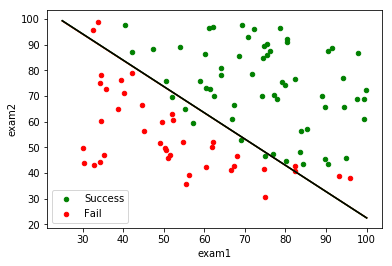

In [6]:
ax = df.where(df['success'] == 1).plot.scatter(
    x='exam1', y='exam2', c='green', label='Success')
df.where(df['success'] == 0).plot.scatter(
    x='exam1', y='exam2', c='red', label='Fail', ax=ax)

Θ = Θ_gd
x1 = np.arange(25, 101)
x2 = -(Θ[0] + Θ[1] * x1) / Θ[2]
ax.plot(x1, x2, c='red')

Θ = Θ_nm
x2 = -(Θ[0] + Θ[1] * x1) / Θ[2]
ax.plot(x1, x2, c='green')

Θ = Θ_bfgs
x2 = -(Θ[0] + Θ[1] * x1) / Θ[2]
ax.plot(x1, x2, c='black')

# PART 2

In [21]:
df = pd.read_csv('Data/Lab 2/ex2data2.txt', names=['test1', 'test2', 'success'])

In [22]:
# Define constants
M, N = df.shape[0], 28

X = df.iloc[:, :-1].to_numpy()
poly = PolynomialFeatures(degree=6)
X = poly.fit_transform(X)

Y = df.iloc[:, -1].to_numpy()

In [23]:
def h(Θ, x):
    """
        Parameters
        ----------
        Θ: array, shape (1, n)
        x: array, shape (m, n)
        
        Returns
        -------
        h_Θx: array, shape (1, m)
    """
    return ss.expit((x*Θ).sum(axis=1))


def predict(grid, Θ):
    """
        Parameters
        ----------
        Θ: array, shape (1, n)
        grid: array, shape (, n)
        
        Returns
        -------
        h_Θx: number
    """
    x1, x2 = grid
    x = np.array([x1.ravel(), x2.ravel()]).T
    poly = PolynomialFeatures(degree=6)
    z = poly.fit_transform(x) * Θ_gd
    h = ss.expit(z.sum(axis=1))
    return h >= 0.5


def COST_F(h_Θx, y):
    """
        Parameters
        ----------
        h_Θx: array, shape (1, m)
        y: array, shape (1, m)
        
        Returns
        -------
        cost: array, shape (1, m)
    """
    y_is_valid = (y == 1) | (y == 0)
    if not y_is_valid.all():
        raise ValueError(f'\'y\' must be 0 or 1, not {y}')
    return (y-1)*np.log(1-h_Θx) - y*np.log(h_Θx)


def J(Θ, λ, x=X, y=Y, m=M):
    """
        Parameters
        ----------
        Θ: array, shape (m, 1)
        x: array, shape (m, n)
        y: array, shape (m, 1)
        λ: number
        m: number
        
        Returns
        -------
        J_Θ: number
    """
    h_Θx = h(Θ, x)
    cost = COST_F(h_Θx, y)
    J_Θ = (cost.sum() + λ*(Θ[1:]**2).sum()) / m
    return J_Θ


def GD(Θ, λ, α=0.03, y=Y, x=X, m=M):
    """
        Parameters
        ----------
        Θ: array, shape (m, 1)
        x: array, shape (m, n)
        y: array, shape (m, 1)
        α: number
        λ: number
        m: number
        
        Returns
        -------
        Θ_new: array, shape (m, 1)
    """
    for i in range(10**4):
        h_Θx = h(Θ, x)
        Θ_new = Θ * (1 - α*λ/m) - α * x.T.dot(h_Θx - y) / m
        
        J_Θ, J_Θ_new = J(Θ, λ), J(Θ_new, λ)
        ΔJ = J_Θ - J_Θ_new
        
        if ΔJ < 0:
            α /= 2
            continue
        elif ΔJ < 10**(-9):
            break
    
        Θ = Θ_new

    return Θ_new

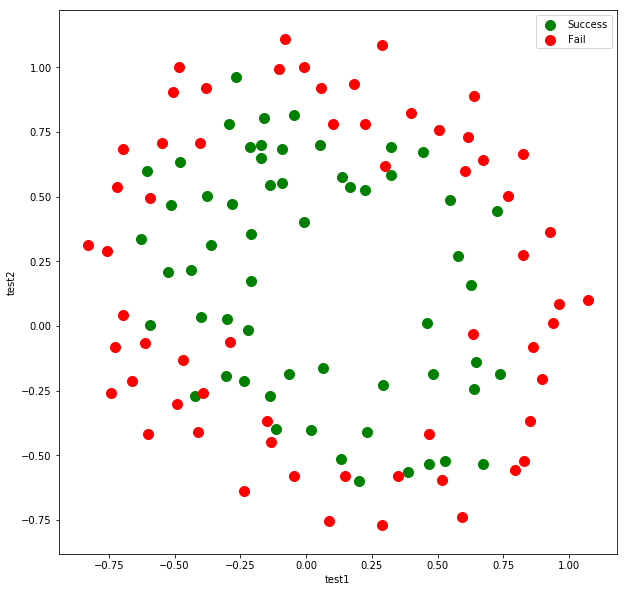

In [24]:
_, ax = plt.subplots(figsize=(10, 10))

Θ_gd = GD(np.zeros(N), λ=0)

df.where(df['success'] == 1).plot.scatter(
    x='test1', y='test2', c='green', label='Success', ax=ax, s=100)
df.where(df['success'] == 0).plot.scatter(
    x='test1', y='test2', c='red', label='Fail', ax=ax, s=100)

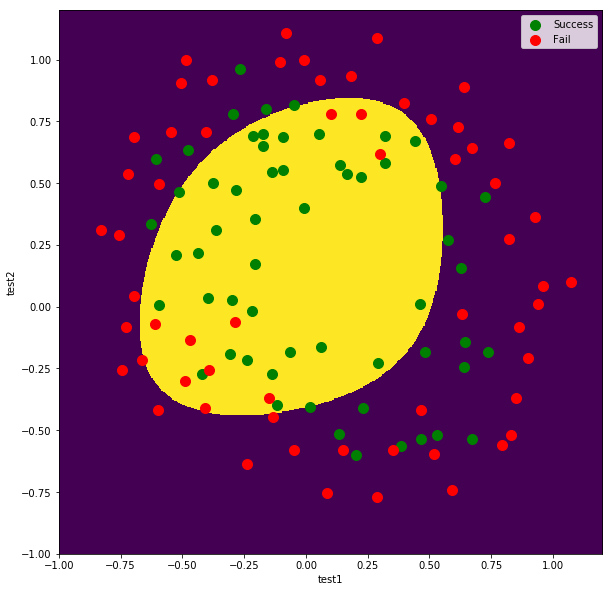

In [25]:
_, ax = plt.subplots(figsize=(10, 10))

Θ_gd = GD(np.zeros(N), λ=0)

df.where(df['success'] == 1).plot.scatter(
    x='test1', y='test2', c='green', label='Success', ax=ax, s=100)
df.where(df['success'] == 0).plot.scatter(
    x='test1', y='test2', c='red', label='Fail', ax=ax, s=100)


grid = np.meshgrid(
    np.arange(-1, 1.5, 0.005), 
    np.arange(-1, 1.5, 0.005))

y = predict(grid, Θ_gd) 
im = ax.imshow(y.reshape(grid[0].shape[0], grid[1].shape[0]), extent=[-1, 1.2, -1, 1.2])

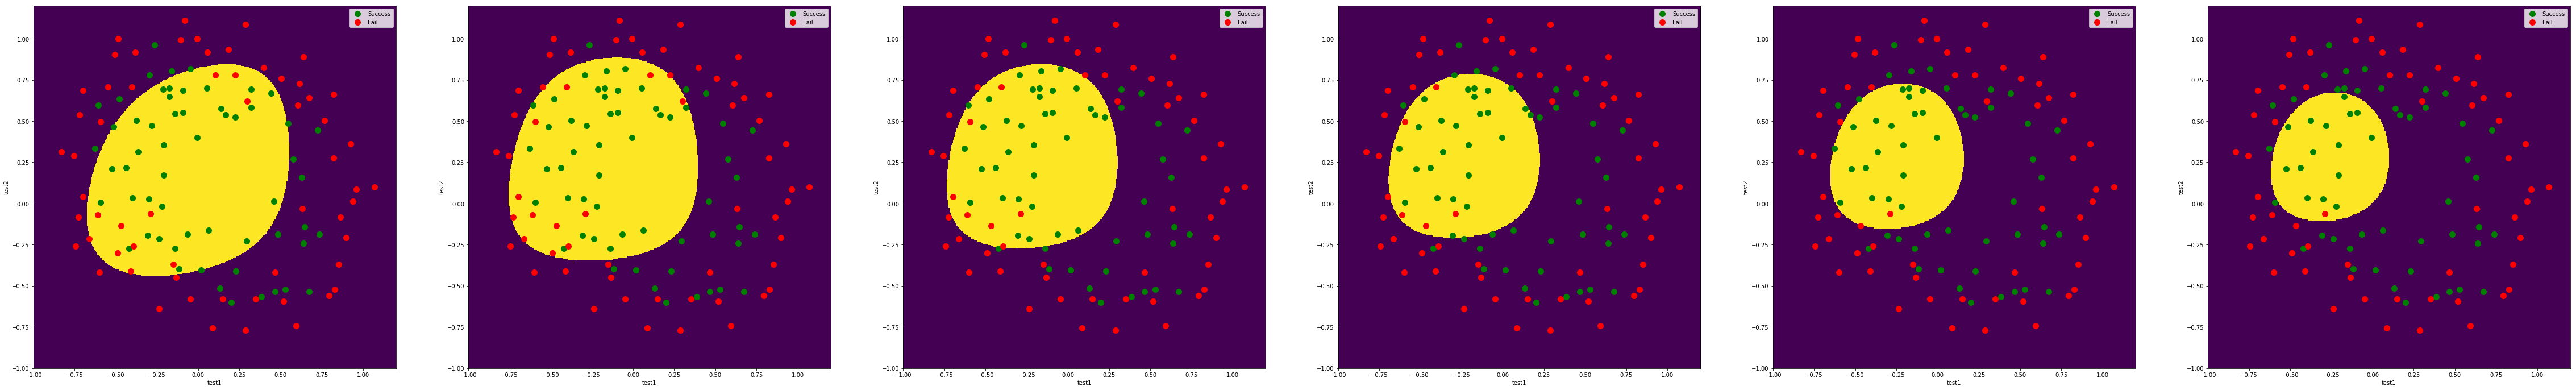

In [40]:
_, ax = plt.subplots(1, 6, figsize=(80, 12))
for i, λ in enumerate(range(0, 26, 5)):
    Θ_gd = GD(np.zeros(N), λ=λ)

    df.where(df['success'] == 1).plot.scatter(
        x='test1', y='test2', c='green', label='Success', ax=ax[i], s=100)
    df.where(df['success'] == 0).plot.scatter(
        x='test1', y='test2', c='red', label='Fail', ax=ax[i], s=100)


    grid = np.meshgrid(
        np.arange(-1, 1.5, 0.005), 
        np.arange(-1, 1.5, 0.005))

    y = predict(grid, Θ_gd) 
    im = ax[i].imshow(y.reshape(grid[0].shape[0], grid[1].shape[0]), extent=[-1, 1.2, -1, 1.2])


# PART 3

In [11]:
matdata = loadmat('Data/Lab 2/ex2data3.mat')

In [12]:
M = 5000
N1, N2 = 20, 20
N = N1 * N2

IMGAGES = matdata['X'].reshape(M, N1, N2)
X = matdata['X']
Y = matdata['y']

DIG_MAP = { digit: y_val[0] for digit, y_val in zip(range(10), Y[::500]) }

In [13]:
X = np.concatenate((np.ones((M, 1)), X), axis=1)
N = 401

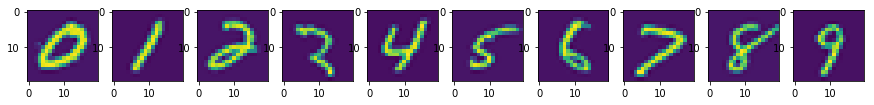

In [14]:
fig, axs = plt.subplots(1, 10, figsize=(15,15))

for digit in sorted(DIG_MAP):
    start, end = digit*500, (digit+1)*500
    img = IMGAGES[start:end][50]
    axs[digit].imshow(img.T)

In [15]:
def h(Θ, x):
    """
        Parameters
        ----------
        Θ: array, shape (1, n)
        x: array, shape (m, n)
        
        Returns
        -------
        h_Θx: array, shape (1, m)
    """
    z = x*Θ
    z = z.sum(axis=1)
    return 1 / (1 + np.exp(-z))


def COST_F(h_Θx, y):
    """
        Parameters
        ----------
        h_Θx: array, shape (1, m)
        y: array, shape (1, m)
        
        Returns
        -------
        cost: array, shape (1, m)
    """
    return (y-1)*np.log(1-h_Θx) - y*np.log(h_Θx)


def J(Θ, λ, x=X, y=Y):
    """
        Parameters
        ----------
        Θ: array, shape (m, 1)
        x: array, shape (m, n)
        y: array, shape (m, 1)
        λ: number
        
        Returns
        -------
        J_Θ: number
    """
    m = len(x)
    h_Θx = h(Θ, x)
    cost = COST_F(h_Θx, y)
    J_Θ = (cost.sum() + λ*(Θ[1:]**2).sum()) / m
    return J_Θ


def GD(Θ, x, y, *, λ=0, α=1, ϵ=1e-7, niter=int(1e+4)):
    """
        Parameters
        ----------
        Θ: array, shape (m, 1)
        x: array, shape (m, n)
        y: array, shape (m, 1)
        α: number
        λ: number
        
        Returns
        -------
        Θ_new: array, shape (m, 1)
    """
    m, n = x.shape
    for i in range(niter):
        h_Θx = h(Θ, x)
        Δ = h_Θx - y
        
        Θ_new = Θ * (1 - α*λ/m) - α * x.T.dot(h_Θx - y) / m
        
        J_Θ, J_Θ_new = J(Θ, λ, x=x, y=y), J(Θ_new, λ, x=x, y=y)
        ΔJ = J_Θ - J_Θ_new
        
        if ΔJ < 0:
            α /= 3
#             print(i, α)
            continue
        elif ΔJ < ϵ:
            break
    
        Θ = Θ_new

    print('niter: ', i)
    return Θ_new


def eval_Θ(digit, x, y, *, λ, α, niter, ϵ):
    """
        Parameters
        ----------
        digit: number
        λ: number
        x:     array, shape (m, n)
        y:     array, shape (m, 1)
        
        Returns
        -------
        Θ_new: array, shape (1, m)
    """
    x = X
    y = np.array([int(yi == digit) for yi in y])

    Θ_zero = np.zeros(N)
    Θ = GD(Θ_zero, x, y, λ=λ, α=α, niter=niter, ϵ=ϵ)
    return Θ


def classify(x, Θ):
    """
        Parameters
        ----------
        
        x: array, shape (1, n)
        Θ: array, shape (1, n)
        
        Returns
        -------
        digit: number
    """
    predictions = np.array([h(Θi, np.array([x])) for Θi in Θ])
    return DIG_MAP[np.argmax(predictions)]

In [16]:
Θ = np.array([
    eval_Θ(DIG_MAP[i], x=X, y=Y, λ=0.5, α=3, niter=int(1e+4), ϵ=1e-7)
    for i in range(10)
])
Θ.shape

0 1.0
1 0.3333333333333333
9101
0 1.0
4215
0 1.0
1 0.3333333333333333
9999
0 1.0
1 0.3333333333333333
9999
0 1.0
4156
0 1.0
1 0.3333333333333333
9999
0 1.0
1 0.3333333333333333
9999
0 1.0
4036
0 1.0
1 0.3333333333333333
9999
0 1.0
1 0.3333333333333333
9999


(10, 401)

In [17]:
y = np.array([classify(x, Θ) for x in X])

In [18]:
stat = Counter(*(y == Y.T))
accurancy = stat[True] / M
accurancy

0.9424